## 1. 데이터 불러오기 & 전처리 함수

In [1]:
import pandas as pd
import numpy as np
import time
import numpy as np
import re

In [2]:
BillDf = pd.read_csv("./21대 국회 의안정보 new.csv", encoding='utf-8-sig') #200824업데이트
BillDf.head()

,의안번호,처리여부,의안명,제안자구분,제안일자,의결일자,의결결과,심사진행상태,문서,제안회기,제안이유,소관위원회,제안자
0,2103236,계,유통산업발전법 일부개정법률안(박재호의원 등 10인),의원,2020-08-24,NaN,NaN,접수,NaN,제21대 (2020~2024) 제381회,['제안이유 및 주요내용현행법은 대ㆍ중소유통업의 상생발전과 지역상권의 활성화를 도모...,[],"['박재호(더불어민주당/朴在昊)', '김경협(더불어민주당/金炅俠)', '김정호(더불..."
1,2103235,계,도로교통법 일부개정법률안(황운하의원 등 13인),의원,2020-08-24,NaN,NaN,접수,NaN,제21대 (2020~2024) 제381회,['제안이유 및 주요내용현행법은 자동차등이 정지하고 있는 경우 등을 제외하고는 운전...,[],"['황운하(더불어민주당/黃雲夏)', '김경만(더불어민주당/金京萬)', '김경협(더불..."
2,2103234,계,철도산업발전기본법 일부개정법률안(이은주의원 등 30인),의원,2020-08-24,NaN,NaN,접수,NaN,제21대 (2020~2024) 제381회,"['제안이유 및 주요내용정부는 「노인복지법」,「장애인복지법」 등에 따라 65세 이상...",[],"['이은주(정의당/李恩周)', '강민정(열린민주당/姜旼姃)', '강은미(정의당/姜恩..."
3,2103233,계,도시철도법 일부개정법률안(이은주의원 등 29인),의원,2020-08-24,NaN,NaN,접수,NaN,제21대 (2020~2024) 제381회,"['제안이유정부는 「노인복지법」,「장애인복지법」 등에 따라 65세 이상 노인·장애인...",[],"['이은주(정의당/李恩周)', '강민정(열린민주당/姜旼姃)', '강은미(정의당/姜恩..."
4,2103232,계,대중교통의 육성 및 이용촉진에 관한 법률 일부개정법률안(이은주의원 등 29인),의원,2020-08-24,NaN,NaN,접수,NaN,제21대 (2020~2024) 제381회,"['제안이유최근 코로나19 바이러스의 확산에 따라 외출 자제 및 재택근무 권고, 학...",[],"['이은주(정의당/李恩周)', '강민정(열린민주당/姜旼姃)', '강은미(정의당/姜恩..."


In [3]:
##### 전처리 함수 #####


def preprocessing(BillDf):
    
    
    
    # [의안번호] ZZ로 시작하는 행 삭제 
    
    startZ = BillDf[BillDf['의안번호'].str.startswith('ZZ')]

    BillDf.drop(startZ.index, inplace=True)
    BillDf = BillDf.reset_index(drop=True)
    
    
    
    
    # [제안이유] 특수문자 및 '제안이유 및 주요내용', '제안이유', '주요내용' 문자열 삭제
    
    def clean_reason(df_col): 
        text = df_col[2:-2].replace('제안이유 및 주요내용','').replace('대안의 제안이유 및 주요내용','').replace('대안의 주요내용','').replace('대안의 제안이유','').replace('제안이유','').replace('주요내용','')
        return re.sub('[-=.#/:$}·,■?]', ' ', text)
    
    BillDf['제안이유'] = BillDf['제안이유'].apply(lambda x: clean_reason(x))
    
    

    
    
    # [의안명]뒤 대표 제안자 포함 괄호 삭제
    
    for i in range(len(BillDf)):
        BillDf['의안명'][i] = BillDf['의안명'][i].split('(')[0]
        
        
        
        
    # [의안명]에 '법률안' 포함하는 경우만 남기고 삭제 (법률안 -> 4254개 중 4007개) 
    
    BillDf.loc[BillDf['의안명'].str.endswith('법률안') == True, '법률안'] = 1
    BillDf.loc[BillDf['의안명'].str.endswith('법률안') == False, '법률안'] = 0
    BillDf = BillDf[BillDf['법률안'] == 1]
        
        
        
        
    # [제안자구분] 의원, 의장, 위원장 데이터만 남기고 삭제
    
    proposer_type_list = ['의원', '위원장', '의장']
    
    
    BillDf_new = BillDf[BillDf['제안자구분'].isin(proposer_type_list)]
    BillDf = BillDf_new.reset_index(drop = True)
    
    
    
    
    # [제안자] 스플릿, 제안 정당만 따와서 리스트로 변환, 중복제거 -> [제안정당] 칼럼 생성
    
    BillDf['제안자'] = BillDf['제안자'].str.split(',')
    BillDf['제안자'] = BillDf['제안자'].fillna("a") #object of type 'float' has no len() 오류 해결

    list1 = []

    for i in range(len(BillDf)):

        list2 = []

        if BillDf['제안자'][i] != "a":

            for j in range(len(BillDf['제안자'][i])):

                list2.append(BillDf['제안자'][i][j].split('(')[-1].split('/')[0])

            list1.append(list(set(list2)))

        else:
            list1.append(np.NaN)

    BillDf['제안정당'] = list1  
    
    
    
    
    # [제안자구분] '위원장'인 경우 제안정당 -> 더불어민주당으로 채우기
    
    for i in range(len(BillDf)):
        if BillDf['제안자구분'][i]=='위원장':
            BillDf['제안정당'][i]=[]
            BillDf['제안정당'][i].append('더불어민주당')

            

            
    # [소관위원회] 없는 행 제거
    
    noncomm = BillDf[BillDf['소관위원회'] == ''].index
    BillDf.drop(noncomm,inplace=True)
    BillDf = BillDf.reset_index(drop=True)
    
    noncomm = BillDf[BillDf['소관위원회'] == '[]'].index
    BillDf.drop(noncomm,inplace=True)
    BillDf = BillDf.reset_index(drop=True)
    
    
    
    
    # [의결결과] 공포, 미공포 분류
    
    proclaim_list = ['원안가결', '수정가결']
    reject_list = ['임기만료폐기', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기']

    BillDf.loc[BillDf['의결결과'].isin(proclaim_list), '법률공포여부'] = '공포'
    BillDf.loc[BillDf['의결결과'].isin(reject_list), '법률공포여부'] = '미공포'
    
    
    
    
    return BillDf






In [4]:
# 전처리 apply

BillDf = preprocessing(BillDf)

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
BillDf.head()

,의안번호,처리여부,의안명,제안자구분,제안일자,의결일자,의결결과,심사진행상태,문서,제안회기,제안이유,소관위원회,제안자,법률안,제안정당,법률공포여부
0,2103167,계,집회 및 시위에 관한 법률 일부개정법률안,의원,2020-08-21,NaN,NaN,접수,의안원문,제21대 (2020~2024) 제381회,현행 집회 및 시위에 관한 법률에는 헌법재판소의 결정에 따라 해산된 정당의 목적을 ...,행정안전위원회,"[['이원욱(더불어민주당/李元旭)', '강병원(더불어민주당/姜炳遠)', '김민기...",1.0,[더불어민주당],NaN
1,2103166,계,行政訴訟法 일부개정법률안,의원,2020-08-21,NaN,NaN,접수,의안원문,제21대 (2020~2024) 제381회,현행 「행정소송법」은 행정청의 처분에 대한 집행정지 신청사건에 있어서 공공복리에 중...,법제사법위원회,"[['이원욱(더불어민주당/李元旭)', '강병원(더불어민주당/姜炳遠)', '김민기...",1.0,[더불어민주당],NaN
2,2103165,계,범죄수익은닉의 규제 및 처벌 등에 관한 법률 일부개정법률안,의원,2020-08-21,NaN,NaN,접수,의안원문,제21대 (2020~2024) 제381회,현행법은 「형법」상 각종 범죄 밀수출입죄 등 다양한 유형의 중대범죄에 관하여 범죄...,법제사법위원회,"[['이수진(더불어민주당/李秀眞)', '강선우(더불어민주당/姜仙祐)', '강준현...",1.0,"[더불어민주당, 무소속]",NaN
3,2103164,계,조세특례제한법 일부개정법률안,의원,2020-08-21,NaN,NaN,접수,의안원문,제21대 (2020~2024) 제381회,2016년 「해양산업클러스터의 지정 및 육성 등에 관한 특별법」이 제정되었으며 같...,기획재정위원회,"[['박재호(더불어민주당/朴在昊)', '김승남(더불어민주당/金承南)', '김윤덕...",1.0,[더불어민주당],NaN
4,2103162,계,형사소송법 일부개정법률안,의원,2020-08-21,NaN,NaN,접수,의안원문,제21대 (2020~2024) 제381회,「대한민국헌법」 제12조제4항에 따라 피의자도 변호인의 조력을 받을 권리가 있고 ...,법제사법위원회,"[['김남국(더불어민주당/金南局)', '고영인(더불어민주당/高永寅)', '권칠승...",1.0,"[더불어민주당, 열린민주당, 무소속]",NaN


------

## 2. 데이터 살펴보기


#### ① 상임위원회, 특별위원회 개수

In [6]:
BillDf['소관위원회'].value_counts()

행정안전위원회            615
보건복지위원회            443
기획재정위원회            382
환경노동위원회            350
법제사법위원회            325
국토교통위원회            287
정무위원회              287
산업통상자원중소벤처기업위원회    215
교육위원회              181
문화체육관광위원회          137
국회운영위원회            110
농림축산식품해양수산위원회       90
과학기술정보방송통신위원회       87
여성가족위원회             70
외교통일위원회             52
국방위원회               47
정보위원회                4
Name: 소관위원회, dtype: int64

-> 모두 상임위원회!

-------

#### ② 공포, 미공포 구분

In [7]:
BillDf['의결결과'].value_counts()

철회        25
대안반영폐기    23
원안가결      12
수정가결      10
Name: 의결결과, dtype: int64

In [8]:
proclaim = pd.DataFrame(BillDf.groupby('소관위원회')['법률공포여부'].value_counts()).unstack().fillna(0)

proclaim.reset_index(inplace=True)

proclaim.columns = ['소관위원회','공포','미공포']

proclaim['합계'] = proclaim['공포'] + proclaim['미공포']
proclaim['공포율'] = np.round((proclaim['공포'] / proclaim['합계']) * 100)

proclaim.sort_values(by='공포율', ascending=False)
proclaim

,소관위원회,공포,미공포,합계,공포율
0,교육위원회,0.0,3.0,3.0,0.0
1,국토교통위원회,8.0,10.0,18.0,44.0
2,국회운영위원회,2.0,0.0,2.0,100.0
3,기획재정위원회,3.0,2.0,5.0,60.0
4,문화체육관광위원회,2.0,14.0,16.0,12.0
5,법제사법위원회,2.0,6.0,8.0,25.0
6,보건복지위원회,2.0,1.0,3.0,67.0
7,산업통상자원중소벤처기업위원회,0.0,1.0,1.0,0.0
8,정무위원회,0.0,1.0,1.0,0.0
9,행정안전위원회,3.0,5.0,8.0,38.0


-----

#### ③ 정당+위원회 별 개수 확인

In [9]:
party_list = []
for i in BillDf['제안정당']:
    for j in range(0, len(i)):
        party = i[j]
        party_list.append(party)
        
party_list = list(set(party_list))
print(party_list)

['미래통합당', '더불어민주당', '정의당', '열린민주당', '무소속', '국민의당', '기본소득당', '시대전환']


In [10]:
party_df = BillDf['제안정당'].apply(lambda x: pd.Series(x))
party_df.columns = ['제안정당_1','제안정당_2','제안정당_3','제안정당_4','제안정당_5','제안정당_6']

df1 = pd.get_dummies(party_df['제안정당_1'])
df2 = pd.get_dummies(party_df['제안정당_2'])
df3 = pd.get_dummies(party_df['제안정당_3'])
df4 = pd.get_dummies(party_df['제안정당_4'])
df5 = pd.get_dummies(party_df['제안정당_5'])
df6 = pd.get_dummies(party_df['제안정당_6'])

df = df1.add(df2, fill_value=0).add(df3, fill_value=0).add(df4, fill_value=0).add(df5, fill_value=0).add(df6, fill_value=0)

BillDf = pd.concat([BillDf, df], axis=1)

In [11]:
DM = BillDf[BillDf['더불어민주당']==1]
DM = DM.groupby(["소관위원회"])['의안번호'].count()

MT = BillDf[BillDf['미래통합당']==1]
MT = MT.groupby(["소관위원회"])['의안번호'].count()

MS = BillDf[BillDf['무소속']==1]
MS = MS.groupby(["소관위원회"])['의안번호'].count()

KM = BillDf[BillDf['국민의당']==1]
KM = KM.groupby(["소관위원회"])['의안번호'].count()

JE = BillDf[BillDf['정의당']==1]
JE = JE.groupby(["소관위원회"])['의안번호'].count()

YM = BillDf[BillDf['열린민주당']==1]
YM = YM.groupby(["소관위원회"])['의안번호'].count()

KS = BillDf[BillDf['기본소득당']==1]
KS = KS.groupby(["소관위원회"])['의안번호'].count()

SJ = BillDf[BillDf['시대전환']==1]
SJ = SJ.groupby(["소관위원회"])['의안번호'].count()

In [12]:
partylist = [DM, MT, MS, KM, JE, YM, KS, SJ]

PartyComm = pd.merge(DM, MT, on = '소관위원회', how = 'outer')

for i in range(2,8):
    PartyComm = pd.merge(PartyComm, partylist[i], on = '소관위원회', how = 'outer')

PartyComm.columns=['더불어민주당', '미래통합당', '무소속', '국민의당', '정의당', '열린민주당', '기본소득당', '시대전환']

PartyComm['합계'] = PartyComm.sum(axis=1) 

PartyComm.sort_values('합계', ascending=False)

,더불어민주당,미래통합당,무소속,국민의당,정의당,열린민주당,기본소득당,시대전환,합계
소관위원회,,,,,,,,,
행정안전위원회,436,228,178,15.0,33.0,17,28.0,NaN,935.0
보건복지위원회,354,107,85,20.0,33.0,13,6.0,1.0,619.0
기획재정위원회,249,165,110,8.0,14.0,15,15.0,7.0,583.0
환경노동위원회,240,129,75,16.0,42.0,24,22.0,9.0,557.0
법제사법위원회,269,73,60,15.0,31.0,38,30.0,4.0,520.0
정무위원회,237,74,83,6.0,26.0,10,36.0,NaN,472.0
국토교통위원회,190,112,64,19.0,12.0,20,9.0,3.0,429.0
산업통상자원중소벤처기업위원회,145,79,55,NaN,5.0,3,5.0,2.0,294.0
교육위원회,144,48,51,4.0,14.0,23,3.0,1.0,288.0


## 3. 토픽모델링 데이터 준비 & 함수 정의



#### ① 당 + 소관위원회 별 리스트에 텍스트 담기

일단 [더불어민주당, 미래 통합당] -> [행정안전위원회, 보건복지위원회]만 해보자

In [13]:
DM_HA = []
DM_BB = []
MT_HA = []
MT_BB = []



for i in range(len(BillDf)):
    
    for j in range(len(BillDf['제안정당'][i])):
        
        if ('더불어민주당' in BillDf['제안정당'][i][j]) and (BillDf['소관위원회'][i] == '행정안전위원회'):
            DM_HA.append(BillDf['의안명'][i])
            DM_HA.append(BillDf['제안이유'][i])
            
        elif ('더불어민주당' in BillDf['제안정당'][i][j]) and (BillDf['소관위원회'][i] == '보건복지위원회'):
            DM_BB.append(BillDf['의안명'][i])
            DM_BB.append(BillDf['제안이유'][i])
            
        elif ('미래통합당' in BillDf['제안정당'][i][j]) and (BillDf['소관위원회'][i] == '행정안전위원회'):
            MT_HA.append(BillDf['의안명'][i])
            MT_HA.append(BillDf['제안이유'][i])
            
        elif ('미래통합당' in BillDf['제안정당'][i][j]) and (BillDf['소관위원회'][i] == '보건복지위원회'):
            MT_BB.append(BillDf['의안명'][i])
            MT_BB.append(BillDf['제안이유'][i])

----------

#### ② 함수 정의 

In [14]:
import matplotlib.pyplot as plt
from string import punctuation
from konlpy.tag import Kkma, Twitter, Komoran
import time
import datetime
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import collections

In [15]:
stopword = pd.read_csv('./한국어불용어100.txt', sep = "\t")
stopword_list = list(stopword['이'])

In [28]:
           
###################### 텍스트전처리 ######################

def Preproc(textlist):

    
    
    ## 특수문자 제거 & 명사추출


    twitter = Twitter()
    cleanlist = []
    nounlist = []
    removedict = ['법률','경우','것임','대한','신설','규정','현행법','사업','지원','위원회','관리','국가','해당','발생','관련','사항','있음']
        
    for i in range(len(textlist)):
        n = re.sub('[-=.#/:$}·,■?]','',str(textlist[i]))
        k = re.sub('[0-9]','',n)
        nounlist.append(twitter.nouns(k))
    
    for i in nounlist:
        for j in i:
            if len(j)==1:
                i.remove(j)
    for i in nounlist:
        for j in i:
            if j in removedict:
                i.remove(j)
    for i in nounlist:
        for j in i:
            if j in stopword_list:
                i.remove(j)
                

    cleanlist = nounlist
    
    return cleanlist




###################### 상위 50개 단어 제거 ######################


def remove_common(cleanlist):
    

    collections.Counter()

    flat=[]
    for i in cleanlist:
        for j in i:
            if (j not in stopword_list) or (len(j)!=1):
                flat.append(j)
                    
                    
    commoncount = collections.Counter(flat)
    commoncount = commoncount.most_common(50)

    newdict = []

    for i in range(len(commoncount)): #50
        newdict.append(commoncount[i][0])

    for i in cleanlist:
        if i in newdict:
            cleanlist.remove(i)
    
    return cleanlist, newdict







###################### 말뭉치 ######################

def make_corpus(cleanlist):

    dictionary = corpora.Dictionary(cleanlist)
    corpus = [dictionary.doc2bow(text) for text in cleanlist]
    
    return corpus, dictionary, cleanlist




###################### 토픽수최적화 ######################

def coh_visual(corpus, dictionary, cleanlist):
    
    coherence_values = []
    
    for i in range(2,20):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
        coherence_model_lda = CoherenceModel(model = ldamodel, texts = cleanlist, dictionary = dictionary, topn=10)
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_values.append(coherence_lda)
    
    x = range(2,20)
    plt.plot(x, coherence_values)
    plt.xlabel('number of topics')
    plt.ylabel('coherence score')
    plt.show()
    
    
    
    
###################### 언어모델평가 ######################

def perp_visual(corpus, dictionary):
    
    perplexity_values = []
    
    for i in range(2,20):
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
        perplexity_values.append(ldamodel.log_perplexity(corpus))
    
    x = range(2,20)
    plt.plot(x, perplexity_values)
    plt.xlabel('number of topics')
    plt.ylabel('perplexity score')
    plt.show()
    


------

#### ③ 형태소 분석기 TEST


In [17]:
import time
from konlpy.tag import Kkma, Twitter, Komoran

pos_taggers = [('kkma', Kkma()), ('twitter', Twitter()), ('Komoran', Komoran())]
results = []

for name, tagger in pos_taggers:
    tokens = []
    process_time = time.time()
    for text in DM_HA:
        tokens.append(tagger.pos(text))
        
    process_time = time.time() - process_time
    
    print('tagger name = %10s, %.3f secs' % (name, process_time))
    results.append(tokens)

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


tagger name =       kkma, 130.411 secs
tagger name =    twitter, 14.724 secs
tagger name =    Komoran, 5.777 secs


In [32]:
def kkmatest(textlist, stopword_list):

        kkma = Kkma()
        nounlist = []
        # flatlist = []
        
        for i in range(len(textlist)):
            n = re.sub('[-=.#/:$}·,■?]','',textlist[i])
            k = re.sub('[0-9]','',n)
            nounlist.append(kkma.nouns(k))

        for i in nounlist:
            for j in i:
                if (j in stopword_list) or (len(j)==1):
                    i.remove(j)


        return nounlist


    
def twittertest(textlist, stopword_list):

        twitter = Twitter()
        nounlist = []
        # flatlist = []
        
        for i in range(len(textlist)):
            n = re.sub('[-=.#/:$}·,■?]','',textlist[i])
            k = re.sub('[0-9]','',n)
            nounlist.append(twitter.nouns(k))

        for i in nounlist:
            for j in i:
                if (j in stopword_list) or (len(j)==1):
                    i.remove(j)


        return nounlist

    
    
def komorantest(textlist, stopword_list):

        komoran = Komoran()
        nounlist = []
        # flatlist = []
        
        for i in range(len(textlist)):
            n = re.sub('[-=.#/:$}·,■?]','',textlist[i])
            k = re.sub('[0-9]','',n)
            nounlist.append(komoran.nouns(k))

        for i in nounlist:
            for j in i:
                if (j in stopword_list) or (len(j)==1):
                    i.remove(j)


        return nounlist

In [33]:
kkma_result = kkmatest(DM_HA, stopword_list)
twitter_result = twittertest(DM_HA, stopword_list)
komoran_result = komorantest(DM_HA, stopword_list)

print('kkma결과\n',kkma_result[:3])
print('\ntwitter결과\n',twitter_result[:3])
print('\nkomoran결과\n',komoran_result[:3])

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


kkma결과
 [['집회', '시위', '법률', '일부', '일부개정법률안', '개정', '법률안'], ['현행', '집회', '시위', '법률', '헌법', '헌법재판소', '재판소', '결정', '해산', '정당', '목적', '달성', '집단적', '폭행', '협박', '손괴', '방화', '공공', '안녕', '질서', '직접적', '위협', '금지', '있음', '있음국가', '국가', '재난', '상황', '신속', '복구', '사회적', '유지', '불특정', '다수', '국민', '생명권', '보장', '감염병', '확산', '조치', '원칙적', '필요', '신설', '예외적', '법원', '판단', '허용', '안', '제조', '제조제호', '제호', '참고', '참고사항', '사항', '법률안', '이원', '의원', '대표', '대표발의', '발의', '일부', '일부개정법률안', '개정', '의안', '의안번호', '번호', '의결', '전제', '수정', '조정'], ['지방세', '지방세특례제한법', '특례', '제한', '일부', '일부개정법률안', '개정', '법률안']]

twitter결과
 [['집회', '시위', '법률', '일부', '개정', '법률'], ['현행', '집회', '시위', '법률', '헌법재판소', '결정', '해산', '정당', '목적', '달성', '집회', '시위', '집단', '폭행', '협박', '손괴', '방화', '공공', '안녕', '질서', '직접', '위협', '집회', '시위', '대해', '금지', '국가', '재난', '상황', '재난', '복구', '위해', '질서', '유지', '거나', '특정', '다수', '국민', '생명', '보장', '위해', '감염병', '확산', '조치', '집회', '시위', '원칙', '금지', '필요', '신설', '원칙', '금지', '예외', '법원', '판단', '통해', '허용', '제조', '제호', '신설', '참고', '사항', '

## 4. 더불어민주당 토픽모델링

#### ① 더불어민주당 + 행정안전위원회

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


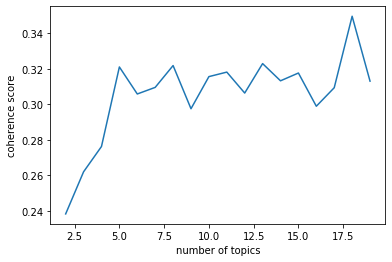

In [17]:
DM_HA_clean = Preproc(DM_HA)
DM_HA_corpus, DM_HA_dictionary, DM_HA_cleanlist = make_corpus(DM_HA_clean)
coh_visual(DM_HA_corpus, DM_HA_dictionary, DM_HA_cleanlist)

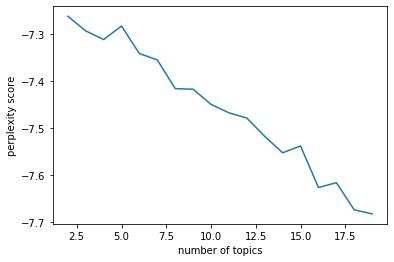

In [18]:
perp_visual(DM_HA_corpus, DM_HA_dictionary)

=> number of topics = 17

In [21]:
ldamodel = gensim.models.ldamodel.LdaModel(DM_HA_corpus, num_topics=17, alpha=0.1, id2word = DM_HA_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, DM_HA_corpus, DM_HA_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3      0.087220  0.002404       1        1  9.167300
1     -0.025644  0.064245       2        1  8.908168
2     -0.073995  0.026009       3        1  7.307652
5      0.021329  0.078734       4        1  7.162511
7      0.072653 -0.005807       5        1  6.803865
8      0.007201 -0.068320       6        1  6.687991
16    -0.056722  0.060164       7        1  6.548793
10     0.065871  0.041861       8        1  6.074854
11     0.023936 -0.021887       9        1  6.048266
14    -0.039880 -0.076414      10        1  5.737119
13    -0.044795  0.012347      11        1  5.508307
9     -0.123604 -0.023439      12        1  5.030984
15     0.043355  0.031708      13        1  4.671265
6     -0.004891  0.003840      14        1  4.448825
4     -0.018226 -0.027401      15        1  3.519536
0      0.064315 -0.052640      16        1  3.469701
12     0.001877 -0.045403      17        1  2.904867, topic_info=      Term        Freq       Total Category  logprob  loglift
2       일부  484.000000  484.000000  Default  30.0000  30.0000
318   소환투표  210.000000  210.000000  Default  29.0000  29.0000
9       국민  419.000000  419.000000  Default  28.0000  28.0000
0       개정  520.000000  520.000000  Default  27.0000  27.0000
313     선거  246.000000  246.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
1137    보상    5.434230   86.620827  Topic17  -5.5828   0.7700
21      보장    5.392506   86.938568  Topic17  -5.5906   0.7586
125     설치    5.947106  173.903183  Topic17  -5.4927   0.1632
99      제도    6.133718  222.230728  Topic17  -5.4618  -0.0511
103     지방    5.972188  342.084198  Topic17  -5.4884  -0.5092

[1232 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2520      5  0.221694   가구
2520      7  0.221694   가구
2520     13  0.443387   가구
545       3  0.555133  가산금
545       4  0.138783  가산금
...     ...       ...  ...
1239      6  0.057294   훈장
1239      7  0.057294   훈장
1239     13  0.401061   훈장
1324      6  0.614541  휠체어
3222      9  0.577446   흐름

[5044 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 6, 8, 9, 17, 11, 12, 15, 14, 10, 16, 7, 5, 1, 13])

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


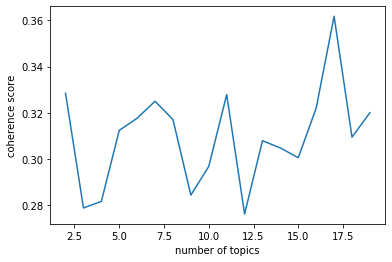

In [17]:
DM_HA_clean = Preproc(DM_HA)
DM_HA_clean, newdict = remove_common(DM_HA_clean)
DM_HA_corpus, DM_HA_dictionary, DM_HA_cleanlist = make_corpus(DM_HA_clean)
coh_visual(DM_HA_corpus, DM_HA_dictionary, DM_HA_cleanlist)

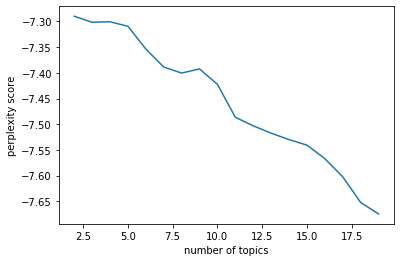

In [18]:
perp_visual(DM_HA_corpus, DM_HA_dictionary)

In [19]:
DM_HA_clean[:3]

[['집회', '시위', '일부', '개정'],
 ['현행',
  '집회',
  '시위',
  '헌법재판소',
  '결정',
  '해산',
  '정당',
  '목적',
  '달성',
  '집회',
  '시위',
  '집단',
  '폭행',
  '협박',
  '손괴',
  '방화',
  '공공',
  '안녕',
  '질서',
  '직접',
  '위협',
  '집회',
  '시위',
  '대해',
  '금지',
  '재난',
  '상황',
  '재난',
  '복구',
  '위해',
  '질서',
  '유지',
  '거나',
  '특정',
  '다수',
  '국민',
  '생명',
  '보장',
  '위해',
  '감염병',
  '확산',
  '조치',
  '집회',
  '시위',
  '원칙',
  '금지',
  '필요',
  '원칙',
  '금지',
  '예외',
  '법원',
  '판단',
  '통해',
  '허용',
  '제조',
  '제호',
  '참고',
  '이원욱',
  '의원',
  '대표',
  '발의',
  '일부',
  '개정',
  '의안',
  '번호',
  '제호',
  '의결',
  '전제',
  '것이므',
  '법률',
  '안이',
  '의결',
  '수정',
  '의결',
  '조정'],
 ['지방세', '특례', '일부', '개정']]

In [20]:
newdict

['제조',
 '개정',
 '일부',
 '지역',
 '국민',
 '지방자치단체',
 '지방',
 '선거',
 '항',
 '제호',
 '경찰',
 '제도',
 '주민',
 '소환투표',
 '운영',
 '국회의원',
 '의결',
 '안전',
 '공무원',
 '함',
 '시설',
 '이상',
 '주택',
 '설치',
 '부동산',
 '마련',
 '정책',
 '인구',
 '자치',
 '활동',
 '구역',
 '후보자',
 '재정',
 '보호',
 '기관',
 '위해',
 '대상',
 '의무',
 '재난',
 '기준',
 '지급',
 '의원',
 '정치',
 '어린이',
 '이하',
 '조정',
 '투표',
 '근거',
 '확보',
 '수행']

In [20]:
ldamodel = gensim.models.ldamodel.LdaModel(DM_HA_corpus, num_topics=16, alpha=0.1, id2word = DM_HA_dictionary)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, DM_HA_corpus, DM_HA_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.022772  0.025970       1        1  15.665920
14     0.008018 -0.022551       2        1  11.317225
10     0.063225 -0.001538       3        1   9.281400
15     0.055076  0.006668       4        1   9.164355
1     -0.011013  0.072206       5        1   6.666262
13    -0.018605  0.109380       6        1   6.278934
12    -0.015760 -0.059855       7        1   6.023501
11     0.102546  0.000159       8        1   5.606962
9      0.032043  0.007975       9        1   5.089107
8     -0.022429 -0.055740      10        1   4.608982
0     -0.137349 -0.032678      11        1   4.275084
2      0.005868 -0.064838      12        1   4.027493
7     -0.012224  0.007896      13        1   3.552445
6     -0.061191  0.047413      14        1   3.333957
5      0.012164 -0.064810      15        1   2.906491
4      0.022404  0.024343      16        1   2.201874, topic_info=      Term        Freq       Total Category  logprob  loglift
0       개정  542.000000  542.000000  Default  30.0000  30.0000
2       일부  506.000000  506.000000  Default  29.0000  29.0000
1022    청원  103.000000  103.000000  Default  28.0000  28.0000
874     경찰  233.000000  233.000000  Default  27.0000  27.0000
318   소환투표  203.000000  203.000000  Default  26.0000  26.0000
...    ...         ...         ...      ...      ...      ...
88      시설    4.625550  178.434769  Topic16  -5.4669   0.1632
0       개정    5.325583  542.799011  Topic16  -5.3260  -0.8084
253     인구    4.168107  158.130722  Topic16  -5.5710   0.1799
35      의안    3.828803   94.474022  Topic16  -5.6559   0.6101
121     마련    4.002134  146.648315  Topic16  -5.6117   0.2147

[1172 rows x 6 columns], token_table=      Topic      Freq Term
term                      
3186      1  0.141741   가능
3186      4  0.141741   가능
3186      5  0.141741   가능
3186      9  0.141741   가능
3186     15  0.283482   가능
...     ...       ...  ...
1388     10  0.069886   희생
1388     11  0.023295   희생
1388     12  0.139773   희생
1388     14  0.046591   희생
1388     16  0.139773   희생

[4619 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 15, 11, 16, 2, 14, 13, 12, 10, 9, 1, 3, 8, 7, 6, 5])

In [19]:
DM_HA_flat=[]
for i in DM_HA_clean:
        for j in i:
            if (j not in stopword_list) or (len(j)!=1):
                    DM_HA_flat.append(j)


In [ ]:
import collections

DM_HA_count = collections.Counter(DM_HA_flat)
DM_HA_count = DM_HA_count.most_common(50)

newdict = []

for i in range(50):
    newdict.append(DM_HA_count[i][0])

for i in DM_HA_clean:
    if i in newdict:
        DM_HA_clean.remove(i)

DM_HA_corpus, DM_HA_dictionary, DM_HA_cleanlist = make_corpus(DM_HA_clean)
coh_visual(DM_HA_corpus, DM_HA_dictionary, DM_HA_cleanlist)

'제조'

In [22]:
def Plzplz(textlist):

    
    
    ## 특수문자 제거 & 명사추출


    twitter = Twitter()
    cleanlist = []
    nounlist = []
    removedict = ['법률','경우','것임','대한','신설','규정','현행법','사업','지원','위원회','관리','국가','해당','발생','관련','사항','있음']
        
    for i in range(len(textlist)):
        n = re.sub('[-=.#/:$}·,■?]','',str(textlist[i]))
        k = re.sub('[0-9]','',n)
        nounlist.append(twitter.nouns(k))

    for i in nounlist:
        for j in i:
            if j in stopword_list:
                i.remove(j)
            elif len(j)==1:
                i.remove(j)
            elif j in removedict:
                i.remove(j)
                

    cleanlist = nounlist
    
    return cleanlist

In [23]:
def lookonce(textlist):
    nounlist = []
    for i in range(len(textlist)):
            n = re.sub('  ','',str(textlist[i]))
            k = re.sub('[0-9]','',n)
            nounlist.append(twitter.nouns(k))
    return nounlist

In [24]:
def plznotone(nounlist, removedict):
    for i in nounlist:
        for j in i:
            if len(j)==1:
                i.remove(j)
    for i in nounlist:
        for j in i:
            if j in removedict:
                i.remove(j)
    return nounlist

In [35]:
twitter = Twitter()
textlist = DM_HA
nounlist = []

for i in range(len(textlist)):
    n = re.sub('  ','',str(textlist[i]))
    k = re.sub('[0-9]','',n)
    nounlist.append(twitter.nouns(k))
            
for i in nounlist:
    for j in i:
        if j in stopword_list:
            i.remove(j)
        elif len(j)==1:
            i.remove(j)
        elif j in removedict:
            i.remove(j)
                
DM_HA_flat=[]
    
for i in nounlist:
    for j in i:
        if (j not in stopword_list) or (len(j)!=1):
            DM_HA_flat.append(j)
    
import collections

DM_HA_count = collections.Counter(DM_HA_flat)
DM_HA_count = DM_HA_count.most_common(50)

newdict = []

for i in range(50):
    newdict.append(DM_HA_count[i][0])

for i in nounlist:
    if i in newdict:
        nounlist.remove(i)

nounlist


/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


[['집회', '시위', '일부', '개정', '법률', '안'],
 ['현행',
  '집회',
  '시위',
  '헌법재판소',
  '결정',
  '해산',
  '정당',
  '목적',
  '달성',
  '집회',
  '시위',
  '집단',
  '폭행',
  '협박',
  '손괴',
  '방화',
  '공공',
  '안녕',
  '질서',
  '직접',
  '위협',
  '집회',
  '시위',
  '대해',
  '금지',
  '재난',
  '상황',
  '재난',
  '복구',
  '위해',
  '질서',
  '유지',
  '거나',
  '특정',
  '다수',
  '국민',
  '생명',
  '보장',
  '위해',
  '감염병',
  '확산',
  '조치',
  '집회',
  '시위',
  '원칙',
  '금지',
  '필요',
  '원칙',
  '금지',
  '예외',
  '법원',
  '판단',
  '통해',
  '허용',
  '안',
  '제조',
  '제호',
  '참고',
  '이원욱',
  '의원',
  '대표',
  '발의',
  '일부',
  '개정',
  '법률',
  '안',
  '의안',
  '번호',
  '제호',
  '의결',
  '전제',
  '것이므',
  '법률',
  '안이',
  '의결',
  '수정',
  '의결',
  '경우',
  '이',
  '조정'],
 ['지방세', '특례', '일부', '개정', '안'],
 ['해양',
  '산업',
  '클러스터',
  '항만',
  '시설',
  '중심',
  '해양',
  '산업',
  '해양',
  '연관',
  '산업',
  '분야',
  '기업',
  '산업',
  '복합',
  '통해',
  '부가가치',
  '출하',
  '제도',
  '년',
  '해양',
  '산업',
  '클러스터',
  '지정',
  '육성',
  '관',
  '특별법',
  '제정',
  '이후',
  '정부',
  '해양',
  '산업',
  '클러스터',
  '기본',
  '계획'